# PID Graph for datasets related to FREYA

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all connections to a publication with a DataCite DOI.

## Prepare the R GraphQl client
Load necessary libraries and set up the API endpoint.

In [175]:
library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

## Generate the GraphQL query
In this query, we are looking through all DataCite DOIs that are assigned to datasets and finding those that include the FREYA grant number within a funding reference. 

Then for each of those datasets, we're asking for:

1. identifiers for the creators (in this case ORCID IDs)
2. identifiers for items related to that dataset (citations, versions, etc.)
3. identifiers for any funders related to that dataset

In this example, we already know that the datasets will have the EC as a related funder, but pulling in the `funderIdentifier` will allow us to plot that information as part of our graph.

In [176]:
query <- '{
  datasets(query: "fundingReferences.awardNumber:777523") {
    totalCount
    nodes {
      id
      creators {
        id
      }
      relatedIdentifiers {
        relatedIdentifier
      }
      fundingReferences {
        funderIdentifier
      }
    }
  }
}'

## Run the query
We'll run the query and process the JSON response it returns.

In [177]:
qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

## Display the number of datasets
This step is just to check our work. We already know there should be only 2 matching datasets (as of 6 June 2019 when this notebook was first created). 

In [178]:
display_json(data$data$datasets$totalCount)

## Generating the graph
First we're going to make sure that all of the DOIs we're receiving are being expressed as URLs. This will help us with de-duping and filtering in later steps.

In [179]:
nodes <- nodes %>% filter(!is.na(as.character(id))) %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% filter(!is.na(as.character(to))) %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

Now let's prepare the data frame. We're defining what all of the nodes are for our graph. 

In [180]:
datasets <- data.frame(id=data$data$datasets$nodes$id, pid_type=c('dataset'))
researchers <- data.frame(id=bind_rows(data$data$datasets$nodes$creators)[,1], pid_type=c('researcher'))
references <- data.frame(id=bind_rows(data$data$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
funders <- data.frame(id=bind_rows(data$data$datasets$nodes$fundingReferences)[,1], pid_type=c('funder'))
nodes <- unique(rbind(datasets, researchers, references, funders))

nodes

,id,pid_type
,<fct>,<fct>
1,https://doi.org/10.5281/zenodo.1202173,dataset
2,https://doi.org/10.5281/zenodo.1263942,dataset
3,https://orcid.org/0000-0003-1419-2405,researcher
4,https://orcid.org/0000-0003-1304-1939,researcher
5,https://orcid.org/0000-0002-2188-2570,researcher
6,https://orcid.org/0000-0002-5355-2576,researcher
7,https://orcid.org/0000-0003-4890-5979,researcher
8,https://orcid.org/0000-0002-8599-0773,researcher
9,https://orcid.org/0000-0002-7368-180X,researcher


Then we define the edges for our graph. We loop through the nodes because each node could have multiple edges.

In [181]:
edges <- data.frame(to=character(), from=character())
nodes_with_creators <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(creators) != 0)
for (i in 1:nrow(nodes_with_creators)) {
  row <- data.frame(to=unlist(nodes_with_creators[i,2]), from=nodes_with_creators[i,1])
  edges <- unique(rbind(edges, row))
}

nodes_with_references <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
for (i in 1:nrow(nodes_with_references)) {
  row <- data.frame(to=unlist(nodes_with_references[i,3]), from=nodes_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

nodes_with_funding <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(fundingReferences) != 0)
for (i in 1:nrow(nodes_with_funding)) {
  row <- data.frame(to=unlist(nodes_with_funding[i,4]), from=nodes_with_funding[i,1])
  edges <- unique(rbind(edges, row))
}

Next we format the graph for display. Here are the formatting choices we're making. 

1. We're going to display only the unique edges and nodes. 
2. We're coloring datasets red, researchers green, publications blue, and funders yellow.
3. We're making the nodes a nice size for viewing. 
4. This is not a directed graph (`relatedidentifiers` don't specify a relational direction), so we don't need to have any arrows. 

In [182]:
g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))
V(g)[(V(g)$pid_type=="dataset")]$color<-'red2'
V(g)[(V(g)$pid_type=="researcher")]$color<-'green3'
V(g)[(V(g)$pid_type=="publication")]$color<-'deepskyblue'
V(g)[(V(g)$pid_type=="funder")]$color<-'gold'
V(g)$size <- 8
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)

And finally, we plot the actual graph. 

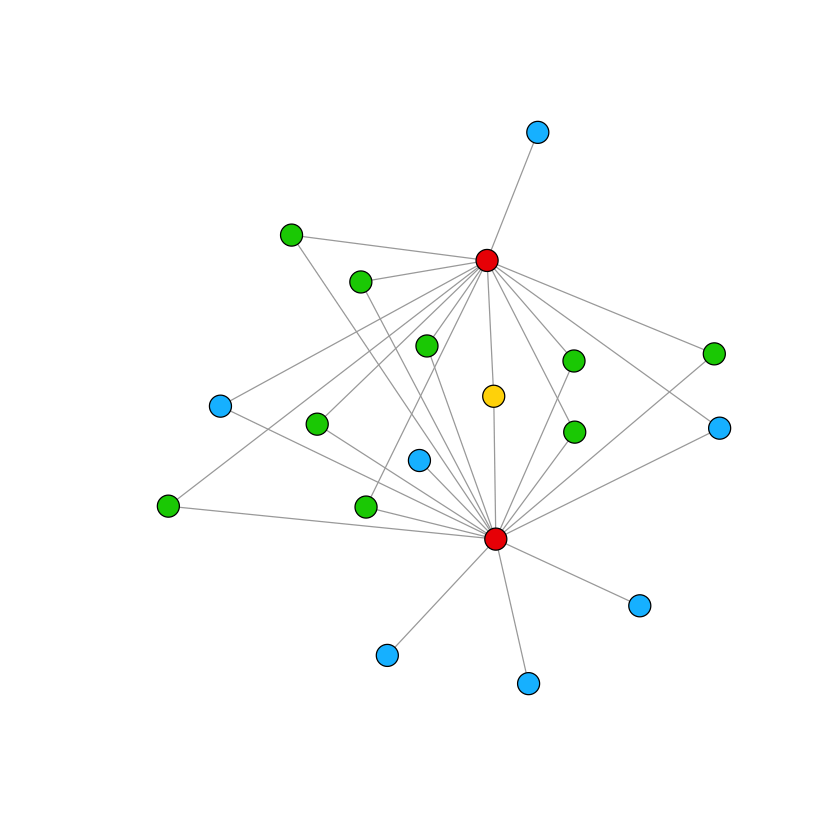

In [183]:
plot(g, vertex.label=NA, layout=l, arrow.mode=0)

## Generate resource lists
We can generate a list of the datasets in APA format. 

In [184]:
ids <- substring(datasets[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Datasets')
display_markdown(content(response, as = 'text'))

## Datasets

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202173

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942

We can also generate a list of all of the publications that were related to these items. 

In [185]:
ids <- references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## References')
display_markdown(content(response, as = 'text'))  

## References

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202174

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202173

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202178

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1262598

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942